# Quantum ROM

In [3]:
# Modules
from qiskit.circuit import QuantumCircuit, QuantumRegister
#from qiskit.quantum_info import Statevector, Operator

#import numpy as np

## 0. Problem Setup
We would want a Qiskit function that takes a boolean function $f:\mathbb{F}_2^n \to \mathbb{F}_2^d$ and outputs a circuit, $U$ such that $$U\ket{x}_n\ket{0}_d = \ket{x}\ket{f(x)}_d$$

## 1. Methods and Details on the Implementation
For simplicity, we consider each of $d$ components of a generic boolean function $f(x)$ to be a sum of bit-wise products of $x_i\in \mathbb{F}_2$ for $i = 1, 2, \dots, n$, i.g. $$f_i(x) = \bigoplus_{t \in \mathcal{T}_i}\prod_{j \in C_i} l_{t,j},\; \text{for } l_{t,j} \in \{x_j,\lnot x_j\}$$where $\mathcal{T_i} \subset \mathbb{N}$ is the set of indices for the summed terms, and $C_i \subset \mathbb{I}_n = \{1, 2,\dots, n\}$.

It is represented by a list of 'indicator' strings as input, e.g. (after applying the method of Karnough maps to some given logic expression or truth table,) for $n = 3$, the minimal boolean expression of $$f_1 = (x_1 \land x_2) \oplus (x_2\land x_3)$$ could be represented as the list of strings `['11-', '-11']`.

Then the binary operations of AND $\land$ and $+\mod 2$/XOR $\oplus$ could be implemented as Toffoli gates and CNOT gates respectively, which leads to the following helper function, and hence the final function as desired.

In [4]:
def processing_pattern_str(qc: QuantumCircuit, x: QuantumRegister,
                           pat_str: str, target):
    '''
    Processing the indicator pattern string by negating the corresponding NOTs
    Args:
        - qc (QuantumCircuit)   :
        - x  (QuantumRegister)  :
        - pat_str (List[str])   : indicator string representing logical expression
    Return:
        None
    '''
    assert len(pat_str) == len(x)
    ctrls = []
    negated = []
    # Flip the nageted literals
    for j, b in enumerate(pat_str):
        if '1' == b:
            ctrls.append(x[j])
        elif '0' == b:
            qc.x(x[j]) # Flip
            negated.append(x[j])
            ctrls.append(x[j])
        # '-' or other placeholding chars ignored.

    # Apply the multi-controlled X into target.
    if 0 == len(ctrls):
        qc.x(target)            # adding a constant TRUE / 1 into target bit = nagation
    elif 1 == len(ctrls):
        qc.cx(ctrls[0], target) # target + ctrl
    elif 2 == len(ctrls):
        qc.ccx(ctrls[0], ctrls[1], target)
    else:
        qc.mcx(ctrls, target)

    # Unflip negated controls
    for q in reversed(negated):
        qc.x(q)

In [5]:
def U_from_list_pattern_str(n: int, lst_pat_str):
    '''
    Uf with d-bit output represented by a list of pattern strings as the sum of logical products
    Args:
        - n (int)               : number of control bits
        - lst (List[List[str]]) : list of pattern strings / sum of products
    '''
    x = QuantumRegister(n, 'x')
    d = len(lst_pat_str)
    y = QuantumRegister(d, 'y')
    qc = QuantumCircuit(x, y, name = 'U_f')

    for i, terms in enumerate(lst_pat_str):
        for pat in terms:
            processing_pattern_str(qc, x, pat, y[i])

    return qc, x, y

## Testing Examples

For $n = 3, d = 2$ consider the logical expression
$$f(x) = [ (\lnot x_1 \land x_2) \oplus (x_1 \land \lnot x_2) , (x_1 \land x_2 \land \lnot x_3)]$$with the list of pattern strings as

`[['01-', '10-'], 
  ['110']]`

In [6]:
n = 3
#d = 2
l_pat_str = [['01-', '10-'], ['110']]
Uf, x, y = U_from_list_pattern_str(n = n,
                                   lst_pat_str = l_pat_str)

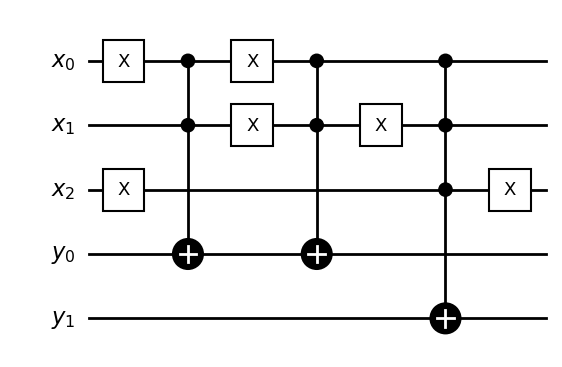

In [7]:
Uf.draw(output = 'mpl', style = 'bw')